In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import json
import numpy as np
import tensorflow as tf

IMG_DIR = 'files/images-2cat'

Take a look at my poor little GPU ¯\\_(ツ)_/¯

In [2]:
from subprocess import Popen, PIPE

process = Popen(['nvidia-smi'], stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()
print(output.decode('utf8'))

Thu Dec  9 22:45:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   44C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
seed = 666
image_size = (256, 256)
# Size to resize images to after they are read from disk.
# Defaults to (256, 256). Since the pipeline processes batches
# of images that must all have the same size, this must be provided. 
batch_size = 2

validation_split=0.33
# float between 0 and 1, fraction of data to reserve for validation. 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6531 files belonging to 2 classes.
Using 4376 files for training.
Found 6531 files belonging to 2 classes.
Using 2155 files for validation.


In [5]:
# Visualize the data
#import matplotlib.pyplot as plt

#plt.figure(figsize=(20, 10))
#for images, labels in train_ds.take(1):
#    for i in range(8):
#        ax = plt.subplot(1, 4, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#        plt.axis("off")

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [16]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    #x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Activation("relu")(x)

    x = layers.Dense(128, activation="ReLU")(x)
    #x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 dense_7 (Dense)             (None, 256, 256, 128)     512       
                                                                 
 dense_8 (Dense)             (None, 256, 256, 1)       129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


### Understanding of the `Output Shape`
`None` means a dynamic dimension of a batch (mini batch). This is why you can set any batch size to your model.

Another way of to explain `None` is that a `None` dimension means that it can be any scalar number, so that you use this model to infer on an arbitrarily long input. This dimension does not affect the size of the network, it just denotes that you are free to select the length (number of samples) of your input during testing.

The remaining elements of the shape tuple is the shape of the corresponding tensor.

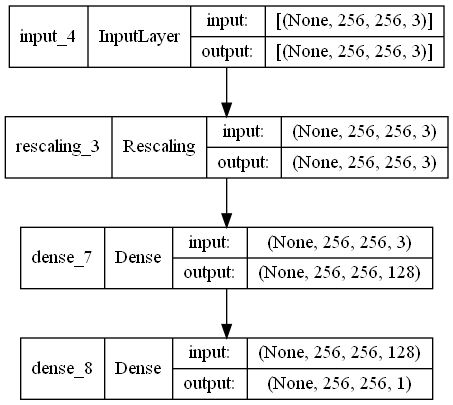

In [19]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
2188/2188 [==============================] - 114s 52ms/step - loss: 0.5662 - accuracy: 0.7489 - val_loss: 0.5782 - val_accuracy: 0.7318
Epoch 2/5
2188/2188 [==============================] - 115s 53ms/step - loss: 0.5604 - accuracy: 0.7509 - val_loss: 0.5759 - val_accuracy: 0.7318
Epoch 3/5
2188/2188 [==============================] - 117s 53ms/step - loss: 0.5576 - accuracy: 0.7509 - val_loss: 0.5742 - val_accuracy: 0.7318
Epoch 4/5
2188/2188 [==============================] - 118s 54ms/step - loss: 0.5554 - accuracy: 0.7509 - val_loss: 0.5738 - val_accuracy: 0.7318
Epoch 5/5
2188/2188 [==============================] - 119s 54ms/step - loss: 0.5538 - accuracy: 0.7509 - val_loss: 0.5712 - val_accuracy: 0.7318
